In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import helpers.images.offline_image_helper as offline_image_helper
from helpers.plotting import basic_plotting
from tensorflow.keras.applications import vgg19

In [298]:
content_loc = "/home/prajith_v/Pictures/face_content.jpeg"
style_loc = "/home/prajith_v/Pictures/great_painting.jpg"

In [299]:
dream_girl = offline_image_helper.load_image(content_loc,target_size=(512,512))
wave = offline_image_helper.load_image(style_loc,target_size=(512,512))

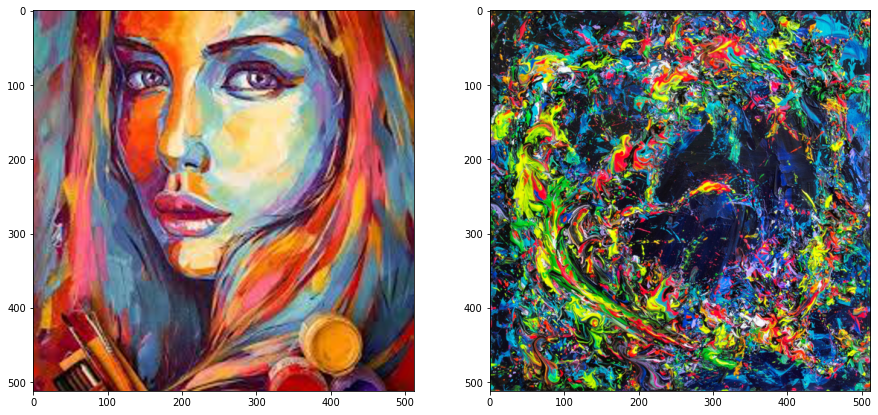

In [300]:
basic_plotting.plot_image_grid([dream_girl,wave])

In [301]:
from PIL import Image
vvv = Image.open(content_loc)

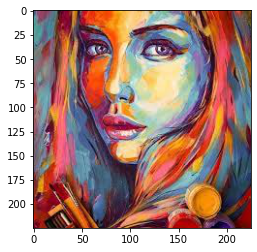

In [302]:
plt.imshow(vvv)

**Coding for model**

.

In [303]:
base_model=vgg19.VGG19(include_top=False,weights="imagenet",)

In [304]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [305]:
CONTENT_LAYERS = ["block5_conv2"]
OUTPUT_LAYERS = ["block4_conv1","block4_conv2","block4_conv3","block4_conv4"]

In [306]:
def make_model(include_full= False,input_shape =None):
    base_model=vgg19.VGG19(include_top=False,weights="imagenet")
    base_model.trainable= False
    content_layers =CONTENT_LAYERS
    style_layers = OUTPUT_LAYERS
    output_layers = [base_model.get_layer(layer).output for layer in (content_layers+style_layers)]
    return tf.keras.models.Model(base_model.input,output_layers)

In [307]:
content_img = dream_girl
style_img = wave

In [308]:
processed_wave = vgg19.preprocess_input(np.expand_dims(style_img,axis=0))
processed_dream_girl = vgg19.preprocess_input(np.expand_dims(content_img,axis=0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


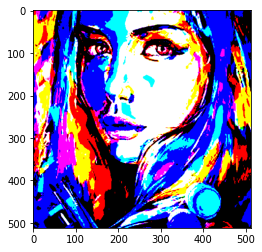

In [309]:
plt.imshow(processed_dream_girl[0,:,:,:].astype(float))

In [310]:
VGG_BIASES = vgg19.preprocess_input((np.zeros((3))).astype("float32"))

In [311]:
VGG_BIASES

array([-103.939, -116.779, -123.68 ], dtype=float32)

In [312]:
# hadjhgj = vgg19.decode_predictions(processed_dream_girl[0])

In [313]:
def deprocess(processed_img):
    unprocessed_img = processed_img-VGG_BIASES
    unprocessed_img = tf.unstack(unprocessed_img,axis=-1)
    unprocessed_img = tf.stack([unprocessed_img[2],unprocessed_img[1],unprocessed_img[0]],axis=-1)
    return unprocessed_img

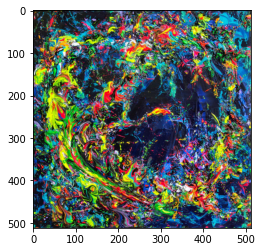

In [314]:
plt.imshow((deprocess(processed_wave)[0])/255)

kjkhwekfhwelfl




In [315]:
base_model= make_model()

In [316]:
dream_girl_outputs = base_model(processed_dream_girl)
wave_outputs= base_model(processed_wave)

In [317]:
processed_wave.shape

(1, 512, 512, 3)

In [318]:
wave_outputs[0].shape

TensorShape([1, 32, 32, 512])

In [319]:
dream_girl_content = dream_girl_outputs[0]

In [320]:
def get_content_loss(new_image_content,base_image_content):
    return np.mean(np.square(new_image_content-base_image_content))

In [321]:
def get_gram_matrix(output):
    first_style_layer = output
    A = tf.reshape(first_style_layer,(-1,first_style_layer.shape[-1])) 
    n = A.shape[0]
    print(A.shape)
    gram_matrix = tf.matmul(A,A,transpose_a=True)
    n=gram_matrix.shape[0]
    return gram_matrix/tf.cast(n,"float32"),n

(4096, 512)


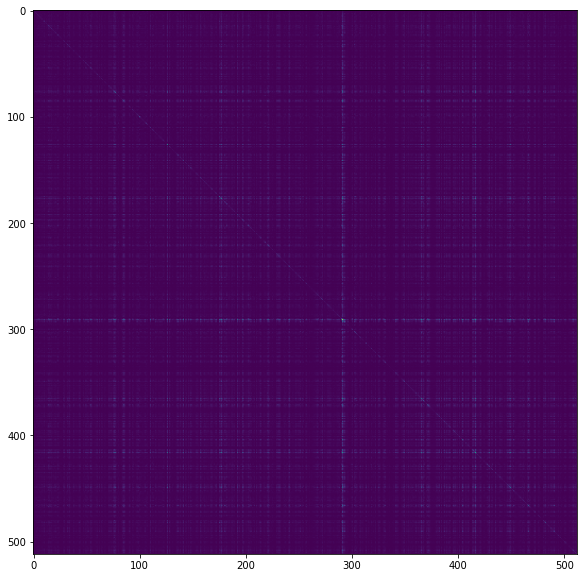

In [322]:
gram_matrix,N = get_gram_matrix(dream_girl_outputs[2])
plt.figure(figsize=(10,10))
plt.imshow(gram_matrix.numpy());

In [323]:
dream_girl_outputs[2].shape

TensorShape([1, 64, 64, 512])

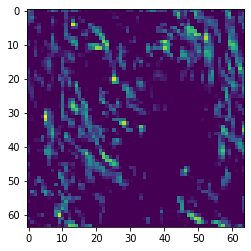

In [324]:
plt.imshow(dream_girl_outputs[2][0,:,:,5])

In [325]:
def get_style_loss(new_image_style,base_style):
    new_style_gram,gram_num_height = get_gram_matrix(new_image_style)
    base_style_gram,gram_num_height2 = get_gram_matrix(base_style)
    gram_num_features = new_style_gram.shape[0]
    loss=tf.reduce_sum(tf.square(base_style_gram-new_style_gram)/(4*(gram_num_height**2)*(gram_num_features**2)))
    return loss

In [326]:
gram_matrix.shape

TensorShape([512, 512])

In [327]:
dream_girl_outputs[4].shape

TensorShape([1, 64, 64, 512])

In [328]:
def get_total_loss(new_image_output,base_content_image_output,base_style_image_output,alpha=.999):
    new_image_styles = new_image_output[len(CONTENT_LAYERS):]
    base_image_styles = base_style_image_output[len(CONTENT_LAYERS):]
    style_loss=0
    N = len(new_image_styles)
    for i in range(N):
        style_loss+=get_style_loss(new_image_styles[i],base_image_styles[i])
    style_loss/=tf.cast(N,dtype="float32")
    
    new_image_contents = new_image_output[:len(CONTENT_LAYERS)]
    base_image_contents = base_content_image_output[:len(CONTENT_LAYERS)]
    content_loss = 0
    N = len(new_image_contents)
    for i in range(N):
        content_loss+=get_content_loss(new_image_contents[i],base_image_contents[i])
    content_loss/=tf.cast(N,dtype="float32")
    
    return (1-alpha)*style_loss+alpha*content_loss

In [329]:
get_total_loss(wave_outputs,dream_girl_outputs,wave_outputs)

(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)


<tf.Tensor: shape=(), dtype=float32, numpy=4544.9136>

In [330]:
wave_style_outputs = base_model(processed_wave)

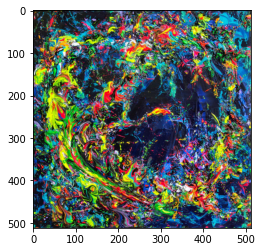

In [331]:
plt.imshow(deprocess(processed_wave)[0]/255)


In [332]:
dream_girl_content_output = base_model(processed_dream_girl)


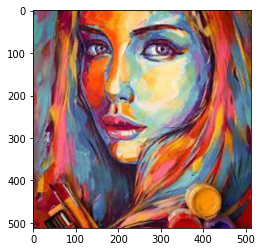

In [333]:
plt.imshow(deprocess(processed_dream_girl)[0]/255)

**dream_girl_outputs = base_model(processed_dream_girl)** \
**wave_outputs= base_model(processed_wave)**

In [334]:
processed_content_var = tf.Variable(processed_dream_girl+tf.random.normal(processed_dream_girl.shape))

In [335]:
optimizer = tf.optimizers.Adam(5,beta_1=.99,epsilon=1e-3)
images = []
losses =[]
i=0
best_loss =200000
min_vals = VGG_BIASES
max_vals = 255+VGG_BIASES

In [336]:
for i in range(30):   
    with tf.GradientTape() as tape:
        tape.watch(processed_content_var)
        content_var_outputs = base_model(processed_content_var)
        loss = get_total_loss(content_var_outputs,dream_girl_content_output,wave_style_outputs,alpha=.97)
        grad = tape.gradient(loss,processed_content_var)
        losses.append(loss)
        optimizer.apply_gradients(zip([grad],[processed_content_var]))
        clipped = tf.clip_by_value(processed_content_var, min_vals, max_vals)
        processed_content_var.assign(clipped)
        if i%5 ==0:
            images.append(deprocess(processed_content_var))
        if loss<best_loss:
            best_image = processed_content_var
            best_loss=loss
        #display(loss)
        #clear_output(wait=True)
    print(i)

(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
0
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
1
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
2
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
3
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
4
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
5
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
6
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
7
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
8
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
(4096, 512)
9
(4096, 512)
(4096, 5

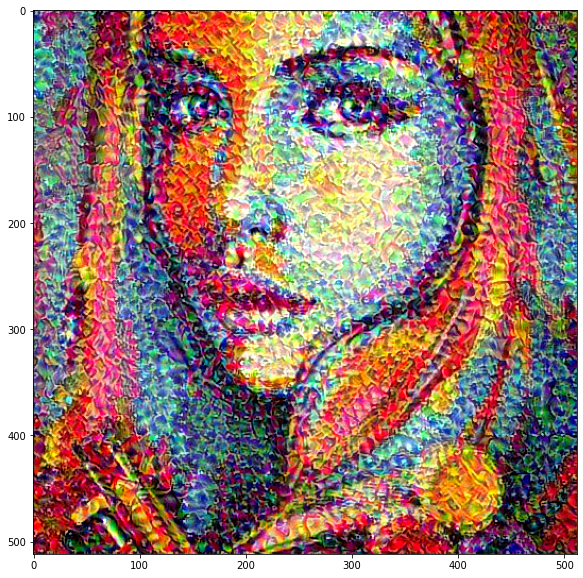

In [337]:
deprocessed_best_image = deprocess(best_image)

plt.figure(figsize=(10,10))
plt.imshow(deprocessed_best_image[0]/255)

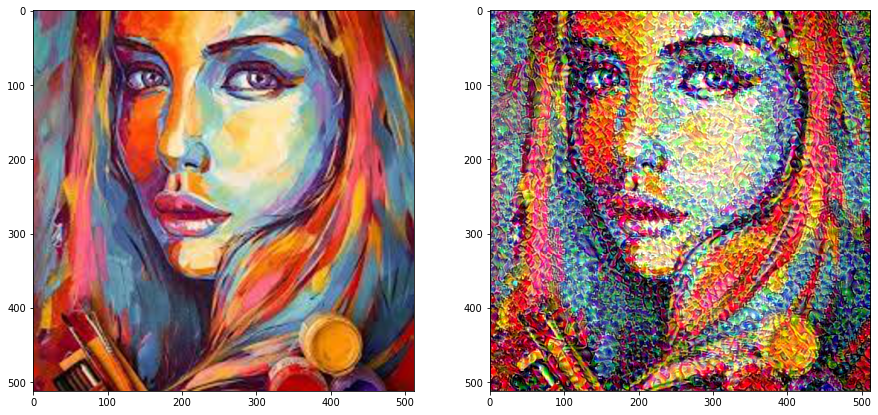

In [338]:
basic_plotting.plot_image_grid([dream_girl,deprocessed_best_image[0]/255])